In [1]:
caffe_root = '../' # this file should be run from {caffe_root}/examples
import caffe

caffe.set_device(0)
caffe.set_mode_gpu()

import numpy as np
from matplotlib.pylab import *
%matplotlib inline

In [2]:
import tempfile

In [3]:
# Helper function for deprocessing preprocessing images, ex. for display
def deprocess_net_image(image):
    image = image.copy()            # don't modify original
    image = image[::-1]             # BGR -> RGB 
    image = image.transpose(1,2,0)  # CHW -> HWC
    image += [123,117,104]          # (approximately) undo mean subtraction
    
    # clamp values in [0, 255]
    image[image<0], image[image > 255] = 0, 255
    
    # round and cast from float 32 to uint8
    image = np.round(image)
    image = np.require(image, dtype=np.uint8)
    
    return image

In [4]:
# Download just a small subset of the data for this exercise.
# (2000 of 80K images, 5 of 20 labels.)
# To download the entire dataset, set `full_dataset = True`.
full_dataset = False
if full_dataset:
    NUM_STYLE_IMAGES = NUM_STYLE_LABELS = -1
else:
    NUM_STYLE_IMAGES = 2000
    NUM_STYLE_LABELS = 5

In [5]:
import os
weights = caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'
assert os.path.exists(weights)

In [6]:
# Load ImageNet labels to imagenet_labels
imagenet_label_file = caffe_root + 'data/ilsvrc12/synset_words.txt'
imagenet_labels = list(np.loadtxt(imagenet_label_file, str, delimiter='\t'))
assert len(imagenet_labels) == 1000
print 'Loaded ImageNet labels:\n', '\n'.join(imagenet_labels[:10] + ['...'])

Loaded ImageNet labels:
n01440764 tench, Tinca tinca
n01443537 goldfish, Carassius auratus
n01484850 great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
n01491361 tiger shark, Galeocerdo cuvieri
n01494475 hammerhead, hammerhead shark
n01496331 electric ray, crampfish, numbfish, torpedo
n01498041 stingray
n01514668 cock
n01514859 hen
n01518878 ostrich, Struthio camelus
...


In [7]:
# Load style labels to style_labels
style_label_file = caffe_root + 'examples/finetune_flickr_style/style_names.txt'
style_labels = list(np.loadtxt(style_label_file, str, delimiter='\n'))
if NUM_STYLE_LABELS > 0:
    style_labels = style_labels[:NUM_STYLE_LABELS]
print '\nLoaded style labels:\n', ', '.join(style_labels)


Loaded style labels:
Detailed, Pastel, Melancholy, Noir, HDR


## 2. Defining and Running the nets

In [8]:
from caffe import layers as L
from caffe import params as P

In [9]:
weight_param = dict(lr_mult=1, decay_mult=1)
bias_param = dict(lr_mult=2, decay_mult=0)
learned_param = [weight_param, bias_param]

frozen_param = [dict(lr_mult=0)] * 2

def conv_relu(bottom, ks, nout, stride=1, pad=0, group=1,
              param=learned_param,
              weight_filler=dict(type='gaussian', std=0.01),
              bias_filler=dict(type='constant', value=0.1)):
    conv = L.Convolution(bottom, kernel_size=ks, stride=stride,
                         num_output=nout, pad=pad, group=group,
                         param=param, weight_filler=weight_filler,
                         bias_filler=bias_filler)
    return conv, L.ReLU(conv, in_place=True)

def fc_relu(bottom, nout, param=learned_param,
            weight_filler=dict(type='gaussian', std=0.005),
            bias_filler=dict(type='constant', value=0.1)):
    fc = L.InnerProduct(bottom, num_output=nout, param=param,
                        weight_filler=weight_filler,
                        bias_filler=bias_filler)
    return fc, L.ReLU(fc, in_place=True)

def max_pool(bottom, ks, stride=1):
    return L.Pooling(bottom, pool=P.Pooling.MAX, kernel_size=ks, stride=stride)

In [10]:
def caffenet(data, label=None, train=True, num_classes=1000,
             classifier_name='fc8', learn_all=False):
    """Returns a NetSpec specifying CaffeNet, following the original proto text
       specification (./models/bvlc_reference_caffenet/train_val.prototxt)."""
    n = caffe.NetSpec()
    n.data = data
    param = learned_param if learn_all else frozen_param
    n.conv1, n.relu1 = conv_relu(n.data, 11, 96, stride=4, param=param)
    n.pool1 = max_pool(n.relu1, 3, stride=2)
    n.norm1 = L.LRN(n.pool1, local_size=5, alpha=1e-4, beta=0.75)
    n.conv2, n.relu2 = conv_relu(n.norm1, 5, 256, pad=2, group=2, param=param)
    n.pool2 = max_pool(n.relu2, 3, stride=2)
    n.norm2 = L.LRN(n.pool2, local_size=5, alpha=1e-4, beta=0.75)
    n.conv3, n.relu3 = conv_relu(n.norm2, 3, 384, pad=1, param=param)
    n.conv4, n.relu4 = conv_relu(n.relu3, 3, 384, pad=1, group=2, param=param)
    n.conv5, n.relu5 = conv_relu(n.relu4, 3, 256, pad=1, group=2, param=param)
    n.pool5 = max_pool(n.relu5, 3, stride=2)
    n.fc6, n.relu6 = fc_relu(n.pool5, 4096, param=param)
    if train:
        n.drop6 = fc7input = L.Dropout(n.relu6, in_place=True)
    else:
        fc7input = n.relu6
    n.fc7, n.relu7 = fc_relu(fc7input, 4096, param=param)
    if train:
        n.drop7 = fc8input = L.Dropout(n.relu7, in_place=True)
    else:
        fc8input = n.relu7
    # always learn fc8 (param=learned_param)
    fc8 = L.InnerProduct(fc8input, num_output=num_classes, param=learned_param)
    # give fc8 the name specified by argument `classifier_name`
    n.__setattr__(classifier_name, fc8)
    if not train:
        n.probs = L.Softmax(fc8)
    if label is not None:
        n.label = label
        n.loss = L.SoftmaxWithLoss(fc8, n.label)
        n.acc = L.Accuracy(fc8, n.label)
    # write the net to a temporary file and return its filename
    with tempfile.NamedTemporaryFile(delete=False) as f:
        f.write(str(n.to_proto()))
        return f.name

In [11]:
dummy_data = L.DummyData(shape=dict(dim=[1, 3, 227, 227]))
imagenet_net_filename = caffenet(data=dummy_data, train=False)
imagenet_net = caffe.Net(imagenet_net_filename, weights, caffe.TEST)

In [12]:
train = True
subset = None
if subset is None:
    subset = 'train' if train else 'test'
source = caffe_root + 'data/flickr_style/%s.txt' % subset
print(source)
!cat $source

../data/flickr_style/train.txt
C:\Users\SoMa\myworkspace\ms_caffe_git\caffe-master\caffe-master\data\flickr_style\images\10344996196_1117743cfe.jpg 0
C:\Users\SoMa\myworkspace\ms_caffe_git\caffe-master\caffe-master\data\flickr_style\images\10878451835_36f42c8288.jpg 0
C:\Users\SoMa\myworkspace\ms_caffe_git\caffe-master\caffe-master\data\flickr_style\images\2219475505_cddf77b23f.jpg 3
C:\Users\SoMa\myworkspace\ms_caffe_git\caffe-master\caffe-master\data\flickr_style\images\13303239423_a3fa85f3ea.jpg 4
C:\Users\SoMa\myworkspace\ms_caffe_git\caffe-master\caffe-master\data\flickr_style\images\12381079055_d882dfca2a.jpg 4
C:\Users\SoMa\myworkspace\ms_caffe_git\caffe-master\caffe-master\data\flickr_style\images\13227395713_a51e989a54.jpg 2
C:\Users\SoMa\myworkspace\ms_caffe_git\caffe-master\caffe-master\data\flickr_style\images\12655578693_9f484287d0.jpg 1
C:\Users\SoMa\myworkspace\ms_caffe_git\caffe-master\caffe-master\data\flickr_style\images\2741691006_dd6bd8916f.jpg 3
C:\Users\SoMa\mywor

In [13]:
def style_net(train=True, learn_all=False, subset=None):
    if subset is None:
        subset = 'train' if train else 'test'
    source = caffe_root + 'data/flickr_style/%s.txt' % subset
    transform_param = dict(mirror=train, crop_size=227,
        mean_file=caffe_root + 'data/ilsvrc12/imagenet_mean.binaryproto')
    style_data, style_label = L.ImageData(
        transform_param=transform_param, source=source,
        batch_size=50, new_height=256, new_width=256, ntop=2)
    return caffenet(data=style_data, label=style_label, train=train,
                    num_classes=NUM_STYLE_LABELS,
                    classifier_name='fc8_flickr',
                    learn_all=learn_all)

In [14]:
untrained_style_net = caffe.Net(style_net(train=False, subset='train'),
                                weights, caffe.TEST)
untrained_style_net.forward()
style_data_batch = untrained_style_net.blobs['data'].data.copy()
style_label_batch = np.array(untrained_style_net.blobs['label'].data, dtype=np.int32)

In [15]:
def disp_preds(net, image, labels, k=5, name='ImageNet'):
    input_blob = net.blobs['data']
    net.blobs['data'].data[0, ...] = image
    probs = net.forward(start='conv1')['probs'][0]
    top_k = (-probs).argsort()[:k]
    print 'top %d predicted %s labels =' % (k, name)
    print '\n'.join('\t(%d) %5.2f%% %s' % (i+1, 100*probs[p], labels[p])
                    for i, p in enumerate(top_k))

def disp_imagenet_preds(net, image):
    disp_preds(net, image, imagenet_labels, name='ImageNet')

def disp_style_preds(net, image):
    disp_preds(net, image, style_labels, name='style')

actual label = Melancholy


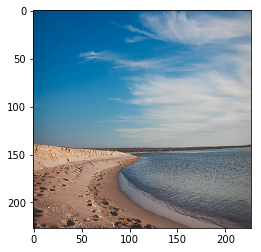

In [16]:
batch_index = 8
image = style_data_batch[batch_index]
plt.imshow(deprocess_net_image(image))
print 'actual label =', style_labels[style_label_batch[batch_index]]

In [17]:
disp_imagenet_preds(imagenet_net, image)

top 5 predicted ImageNet labels =
	(1) 69.89% n09421951 sandbar, sand bar
	(2) 21.76% n09428293 seashore, coast, seacoast, sea-coast
	(3)  3.22% n02894605 breakwater, groin, groyne, mole, bulwark, seawall, jetty
	(4)  1.89% n04592741 wing
	(5)  1.23% n09332890 lakeside, lakeshore


In [18]:
disp_style_preds(untrained_style_net, image)

top 5 predicted style labels =
	(1) 20.00% Detailed
	(2) 20.00% Pastel
	(3) 20.00% Melancholy
	(4) 20.00% Noir
	(5) 20.00% HDR


In [19]:
diff = untrained_style_net.blobs['fc7'].data[0] - imagenet_net.blobs['fc7'].data[0]
error = (diff ** 2).sum()
assert error < 1e-8

In [20]:
del untrained_style_net

In [21]:
from caffe.proto import caffe_pb2

In [22]:
def solver(train_net_path, test_net_path=None, base_lr=0.001):
    s = caffe_pb2.SolverParameter()
    
    # Specify locations of the train and (maybe) test networks.
    s.train_net = train_net_path
    if test_net_path is not None:
        s.test_net.append(test_net_path)
        s.test_interval = 1000 # Test after 1000 training iterations.
        s.test_iter.append(100) # Test on 100 batches each time we test.
    
    # The number of iterations over which to average the gradient.
    # Effectively boosts the training batch size by the given factor, without
    # affecting memory utilization.
    s.iter_size = 1
    
    s.max_iter = 100000     # # of times to update the net (training iterations)
    
    # Solve using the stochastic gradient descent (SGD) algorithm.
    # Other choices include 'Adam' and 'RMSProp'.
    s.type = 'SGD'
    
    # Set the initial learning rate for SGD.
    s.base_lr = base_lr
    
    # Set `lr_policy` to define how the learning rate changes during training.
    # Here, we 'step' the learning rate by multiplying it by a factor `gamma`
    # every `stepsize` iterations.
    s.lr_policy = 'step'
    s.gamma = 0.1
    s.stepsize = 20000
    
    # Set other SGD hyperparameters. Setting a non-zero `momentum` takes a
    # weighted average of the current gradient and previous gradients to make
    # learning more stable. L2 weight decay regularizes learning, to help prevent
    # the model from overfitting.
    s.momentum = 0.9
    s.weight_decay = 5e-4
    
    # Display the current training loss and accuracy every 1000 iterations.
    s.display = 1000
    
    # Snapshots are files used to store networks we've trained.  Here, we'll
    # snapshot every 10K iterations -- ten times during training.
    s.snapshot = 10000
    s.snapshot_prefix = caffe_root + 'models/finetune_flickr_style/finetune_flickr_style'
    
    # Train on the GPU.  Using the CPU to train large networks is very slow.
    s.solver_mode = caffe_pb2.SolverParameter.GPU
    
    # Write the solver to a temporary file and return its filename.
    with tempfile.NamedTemporaryFile(delete=False) as f:
        f.write(str(s))
        return f.name

Now we'll invoke the solver to train the style net's classification layer.

For the record, if you want to train the network using only the command line tool, this is the command:

<code>
build/tools/caffe train \
    -solver models/finetune_flickr_style/solver.prototxt \
    -weights models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel \
    -gpu 0
</code>

However, we will train using Python in this example.

We'll first define `run_solvers`, a function that takes a list of solvers and steps each one in a round robin manner, recording the accuracy and loss values each iteration.  At the end, the learned weights are saved to a file.

In [23]:
!cat C:\Users\SoMa\myworkspace\ms_caffe_git\caffe-master\caffe-master\models\finetune_flickr_style\solver.prototxt

net: "models/finetune_flickr_style/train_val.prototxt"
test_iter: 100
test_interval: 1000
# lr for fine-tuning should be lower than when starting from scratch
base_lr: 0.001
lr_policy: "step"
gamma: 0.1
# stepsize should also be lower, as we're closer to being done
stepsize: 20000
display: 20
max_iter: 100000
momentum: 0.9
weight_decay: 0.0005
snapshot: 10000
snapshot_prefix: "models/finetune_flickr_style/finetune_flickr_style"
# uncomment the following to default to CPU mode solving
# solver_mode: CPU


In [24]:
def run_solvers(niter, solvers, disp_interval=10):
    """Run solvers for niter iterations,
       returning the loss and accuracy recorded each iteration.
       `solvers` is a list of (name, solver) tuples."""
    blobs = ('loss', 'acc')
    loss, acc = ({name: np.zeros(niter) for name, _ in solvers}
                 for _ in blobs)
    for it in range(niter):
        for name, s in solvers:
            s.step(1)  # run a single SGD step in Caffe
            loss[name][it], acc[name][it] = (s.net.blobs[b].data.copy()
                                             for b in blobs)
        if it % disp_interval == 0 or it + 1 == niter:
            loss_disp = '; '.join('%s: loss=%.3f, acc=%2d%%' %
                                  (n, loss[n][it], np.round(100*acc[n][it]))
                                  for n, _ in solvers)
            print '%3d) %s' % (it, loss_disp)     
    # Save the learned weights from both nets.
    weight_dir = tempfile.mkdtemp()
    weights = {}
    for name, s in solvers:
        filename = 'weights.%s.caffemodel' % name
        weights[name] = os.path.join(weight_dir, filename)
        s.net.save(weights[name])
        print("{} solver is saved..".format(weights[name]))
    return loss, acc, weights

In [ ]:
niter = 200  # number of iterations to train

style_solver_filename = solver(style_net(train=True))
style_solver = caffe.get_solver(style_solver_filename)
style_solver.net.copy_from(weights)

# For reference, we also create a solver that isn't initialized from
# the pretrained ImageNet weights.
scratch_style_solver_filename = solver(style_net(train=True))
scratch_style_solver = caffe.get_solver(scratch_style_solver_filename)

print('Running solvers for %d iterations...' % niter)
solvers = [('pretrained', style_solver),
           ('scratch', scratch_style_solver)]
loss, acc, weights = run_solvers(niter, solvers)
print('Done.')

train_loss, scratch_train_loss = loss['pretrained'], loss['scratch']
train_acc, scratch_train_acc = acc['pretrained'], acc['scratch']
style_weights, scratch_style_weights = weights['pretrained'], weights['scratch']

# Delete solvers to save memory.
del style_solver, scratch_style_solver, solvers

Running solvers for 200 iterations...
  0) pretrained: loss=1.609, acc=28%; scratch: loss=1.609, acc=28%
